

# Goal: predict which previously purchased products will be in a user’s next order

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/aisles.csv.zip')
aisles = pd.read_csv(zf.open('aisles.csv'))

In [3]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [4]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/departments.csv.zip')
departments = pd.read_csv(zf.open('departments.csv'))

In [5]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [6]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/products.csv.zip')
products = pd.read_csv(zf.open('products.csv'))

In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [8]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/order_products__prior.csv.zip')
order_products_prior = pd.read_csv(zf.open('order_products__prior.csv'))

In [9]:
order_products_prior.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int64
 1   product_id         32434489 non-null  int64
 2   add_to_cart_order  32434489 non-null  int64
 3   reordered          32434489 non-null  int64
dtypes: int64(4)
memory usage: 989.8 MB


### Only 'days_since_prior_order' column in the orders data have NULL values: when the user is ordering for the first time (order_number =1), the 'days_since_prior_order' is NaN

In [10]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/orders.csv.zip')
orders = pd.read_csv(zf.open('orders.csv'))

In [11]:
orders.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                3421083 non-null  int64  
 1   user_id                 3421083 non-null  int64  
 2   eval_set                3421083 non-null  object 
 3   order_number            3421083 non-null  int64  
 4   order_dow               3421083 non-null  int64  
 5   order_hour_of_day       3421083 non-null  int64  
 6   days_since_prior_order  3214874 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [12]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [13]:
orders[orders['days_since_prior_order'].isnull()]['order_number'].unique()

array([1], dtype=int64)

In [14]:
zf = ZipFile('/Users/minga/DataSci/instacart-market-basket-analysis/order_products__train.csv.zip')
order_products_train = pd.read_csv(zf.open('order_products__train.csv'))

In [15]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


### The last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers



In [16]:
orders.groupby('eval_set')['user_id'].nunique()

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

### Check total order numbers for each customer, ranging from 4 - 100

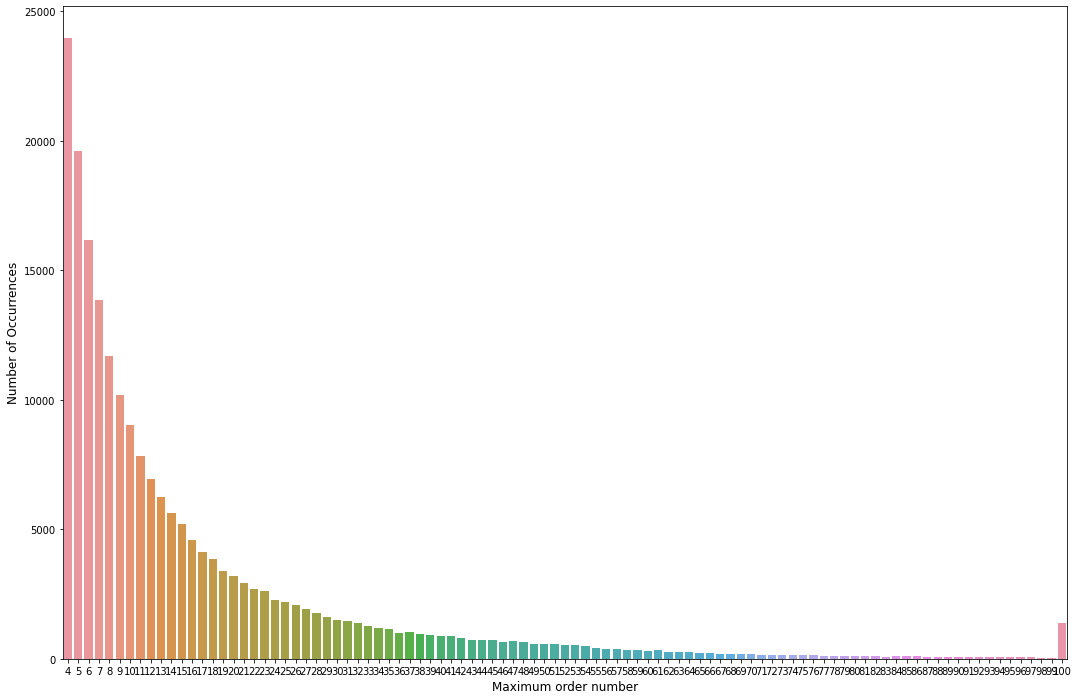

In [17]:
total_orders_user = orders.groupby('user_id')['order_number'].agg(np.max).reset_index()
total_orders_user = total_orders_user.order_number.value_counts()
plt.figure(figsize = (18,12))
sns.barplot(total_orders_user.index, total_orders_user.values)
plt.xlabel('Maximum order number', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12);
#plt.xticks (rotation = 30);

### Check order frequency for each day of the week, hour of the day and etc

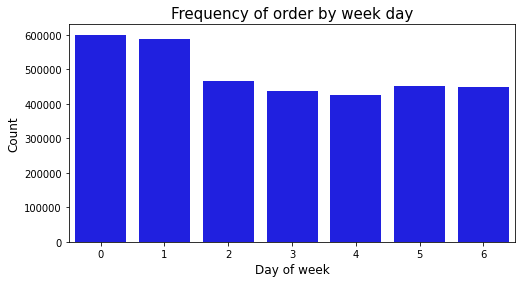

In [18]:
plt.figure(figsize = (8,4))
sns.countplot(x = 'order_dow', data = orders, color = 'blue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15);

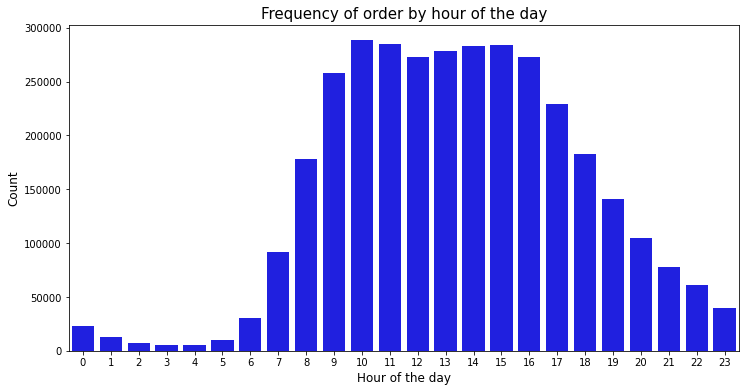

In [19]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'order_hour_of_day', data = orders, color = 'blue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of the day', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of the day", fontsize=15);

In [20]:
dow_hod = orders.groupby(['order_dow','order_hour_of_day'])['order_number'].agg('count').reset_index()
dow_hod.head()

,order_dow,order_hour_of_day,order_number
0,0,0,3936
1,0,1,2398
2,0,2,1409
3,0,3,963
4,0,4,813


In [21]:
dow_hod = dow_hod.pivot('order_dow', 'order_hour_of_day','order_number')

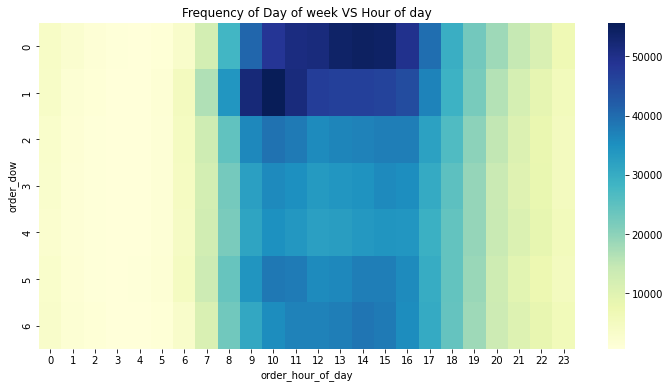

In [22]:
plt.figure(figsize = (12,6))
sns.heatmap(dow_hod, cmap="YlGnBu")
plt.title("Frequency of Day of week VS Hour of day")
plt.show();

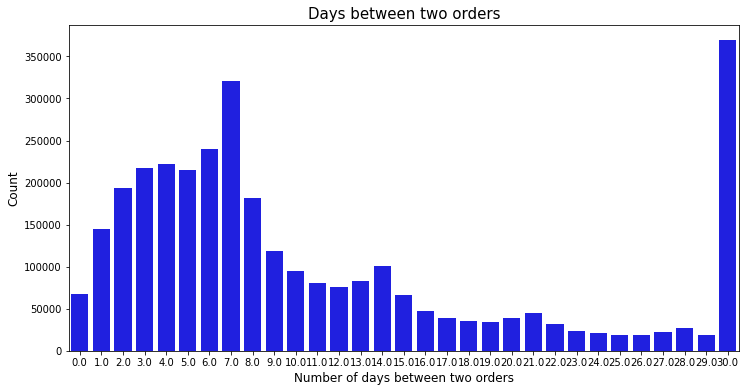

In [23]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'days_since_prior_order', data = orders, color = 'blue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of days between two orders', fontsize=12)
#plt.xticks(rotation='vertical')
plt.title("Days between two orders", fontsize=15);

### On an average, about 59% of the products in an order are re-ordered products.

In [24]:
order_products_train.reordered.sum()/len(order_products_train.reordered)

0.5985944127509629

In [25]:
order_products_prior.reordered.sum()/len(order_products_prior.reordered)

0.5896974667922161

### chances of none of the products are re-ordered: about 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%

In [26]:
order_products_train_group = order_products_train.groupby('order_id')['reordered'].agg('sum').reset_index()
no_reorder = order_products_train_group[order_products_train_group.reordered == 0]
no_reorder.shape[0]/order_products_train_group.shape[0]

0.06555952716658156

In [27]:
order_products_prior_group = order_products_prior.groupby('order_id')['reordered'].agg('sum').reset_index()
no_reorder = order_products_prior_group[order_products_prior_group.reordered == 0]
no_reorder.shape[0]/order_products_prior_group.shape[0]

0.12084859313304347

### the number of products bought in each order: A right tailed distribution with the maximum value at 5

In [28]:
add_to_cart_order_items = order_products_train.groupby('order_id')['add_to_cart_order'].agg('max').reset_index()
add_to_cart_order_items = add_to_cart_order_items.add_to_cart_order.value_counts()

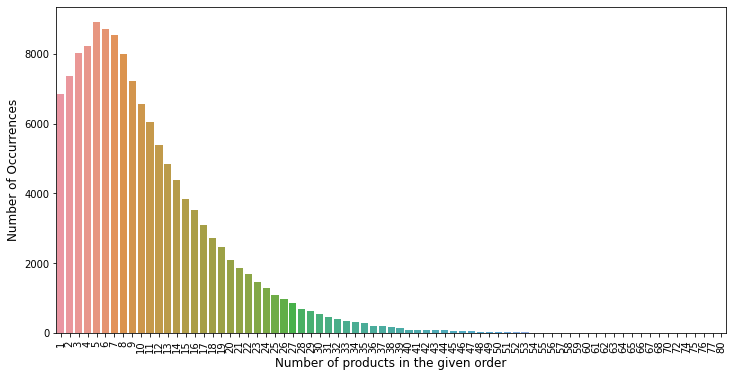

In [29]:
plt.figure(figsize = (12,6))
sns.barplot(add_to_cart_order_items.index, add_to_cart_order_items.values)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show();

### merge product details with the order_prior details

In [30]:
order_products_prior_full = order_products_prior.merge(
    products, on = 'product_id').merge(aisles, on = 'aisle_id').merge(departments, on = 'department_id')

In [31]:
order_products_prior_full.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,26,33120,5,0,Organic Egg Whites,86,16,eggs,dairy eggs
2,120,33120,13,0,Organic Egg Whites,86,16,eggs,dairy eggs
3,327,33120,5,1,Organic Egg Whites,86,16,eggs,dairy eggs
4,390,33120,28,1,Organic Egg Whites,86,16,eggs,dairy eggs


### The top ordered items are organic products and majority of them are fruits

In [32]:
order_product_name = order_products_prior_full['product_name'].value_counts().reset_index()
order_product_name.columns = ['product_name', 'frequency_count']
order_product_name.head()

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584


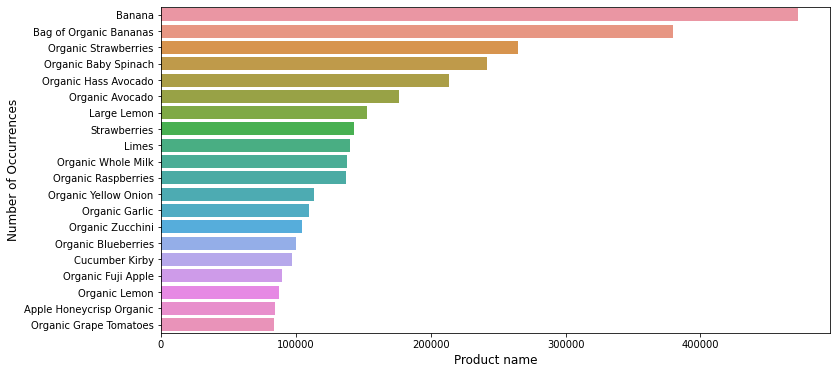

In [33]:
plt.figure(figsize = (12,6))
sns.barplot(y = 'product_name', x = 'frequency_count' ,data = order_product_name[:20])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product name', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()

### The top two aisles are fresh fruits and fresh vegetables

In [34]:
order_product_aisle = order_products_prior_full['aisle'].value_counts().reset_index()
order_product_aisle.columns = ['aisle', 'frequency_count']
order_product_aisle.head()

,aisle,frequency_count
0,fresh fruits,3642188
1,fresh vegetables,3418021
2,packaged vegetables fruits,1765313
3,yogurt,1452343
4,packaged cheese,979763


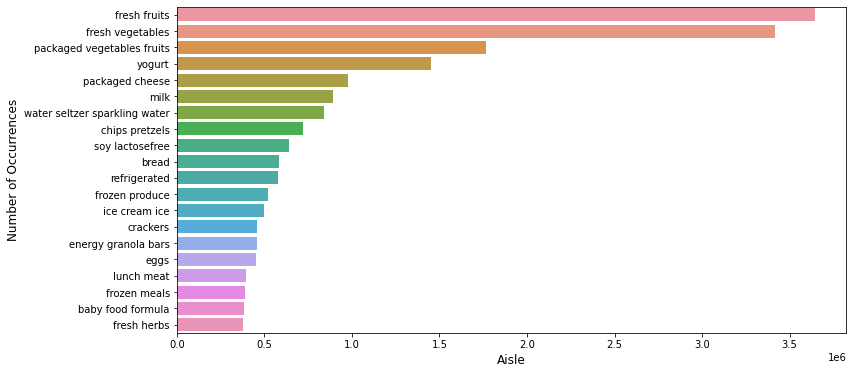

In [35]:
plt.figure(figsize = (12,6))
sns.barplot(y = 'aisle', x = 'frequency_count' ,data = order_product_aisle[:20])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='horizontal')
plt.show()

### The largest department is produce and followed by diary eggs

In [36]:
# DO NOT reset_index(), which matters to the pie chart label 
order_department = order_products_prior_full.department.value_counts(normalize = True)
order_department.columns = ['department', 'frequency_count']
order_department.head()

produce       0.292260
dairy eggs    0.166922
snacks        0.089027
beverages     0.082940
frozen        0.068952
Name: department, dtype: float64

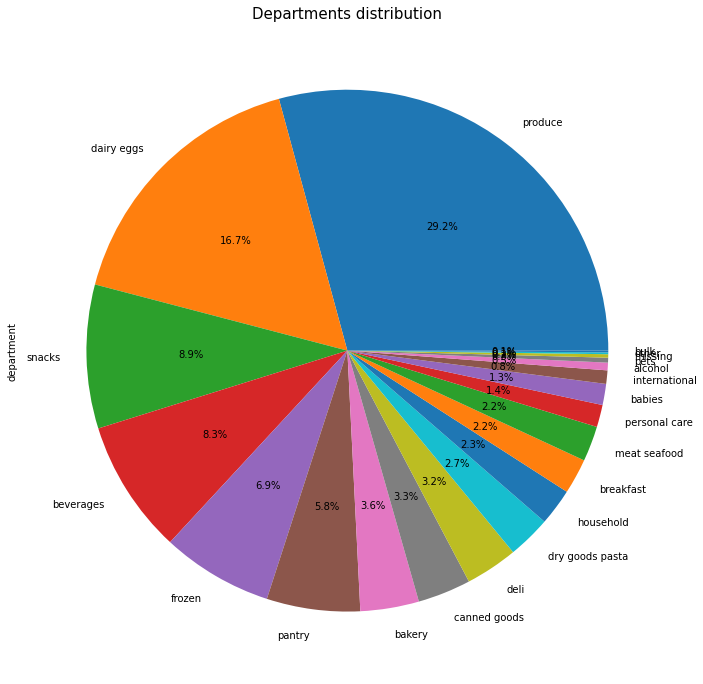

In [37]:
#the autopct automatically calculate the percentage
order_department.plot.pie(y = 'frequency_count', 
                          autopct='%1.1f%%', 
                          legend = False, 
                          title = 'department',
                          #startangle = 20,
                          figsize = (12,12))
plt.title("Departments distribution", fontsize=15);

### reorder ratio for departments
Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio

In [38]:
department_reorder = order_products_prior_full.groupby('department')['reordered'].agg('mean').reset_index()
department_reorder.columns = ['department', 'reordered_percent']
department_reorder.head()

,department,reordered_percent
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


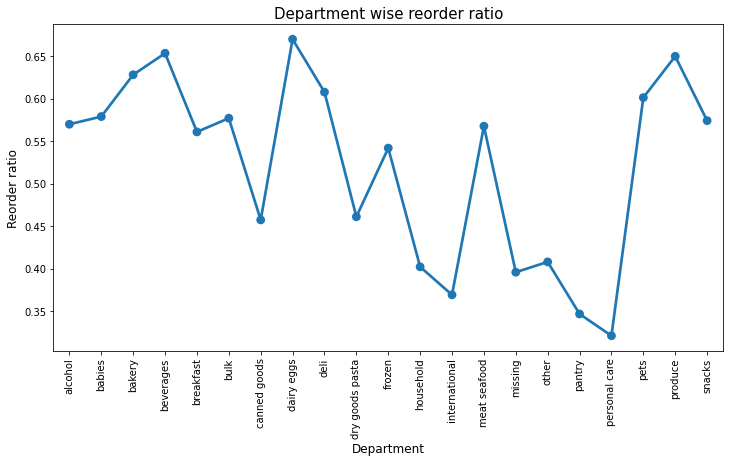

In [39]:
plt.figure(figsize = (12,6))
sns.pointplot(x = 'department', y = 'reordered_percent', data = department_reorder, marker = "o")
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks (rotation = 'vertical');

### Aisle reorder ratio

In [40]:
aisle_reorder = order_products_prior_full.groupby(['aisle_id', 'aisle'])['reordered'].agg('mean').reset_index()
aisle_reorder.columns = ['aisle_id','aisle', 'reordered_percent']
aisle_reorder.head()

,aisle_id,aisle,reordered_percent
0,1,prepared soups salads,0.596597
1,2,specialty cheeses,0.489326
2,3,energy granola bars,0.598007
3,4,instant foods,0.489533
4,5,marinades meat preparation,0.280627


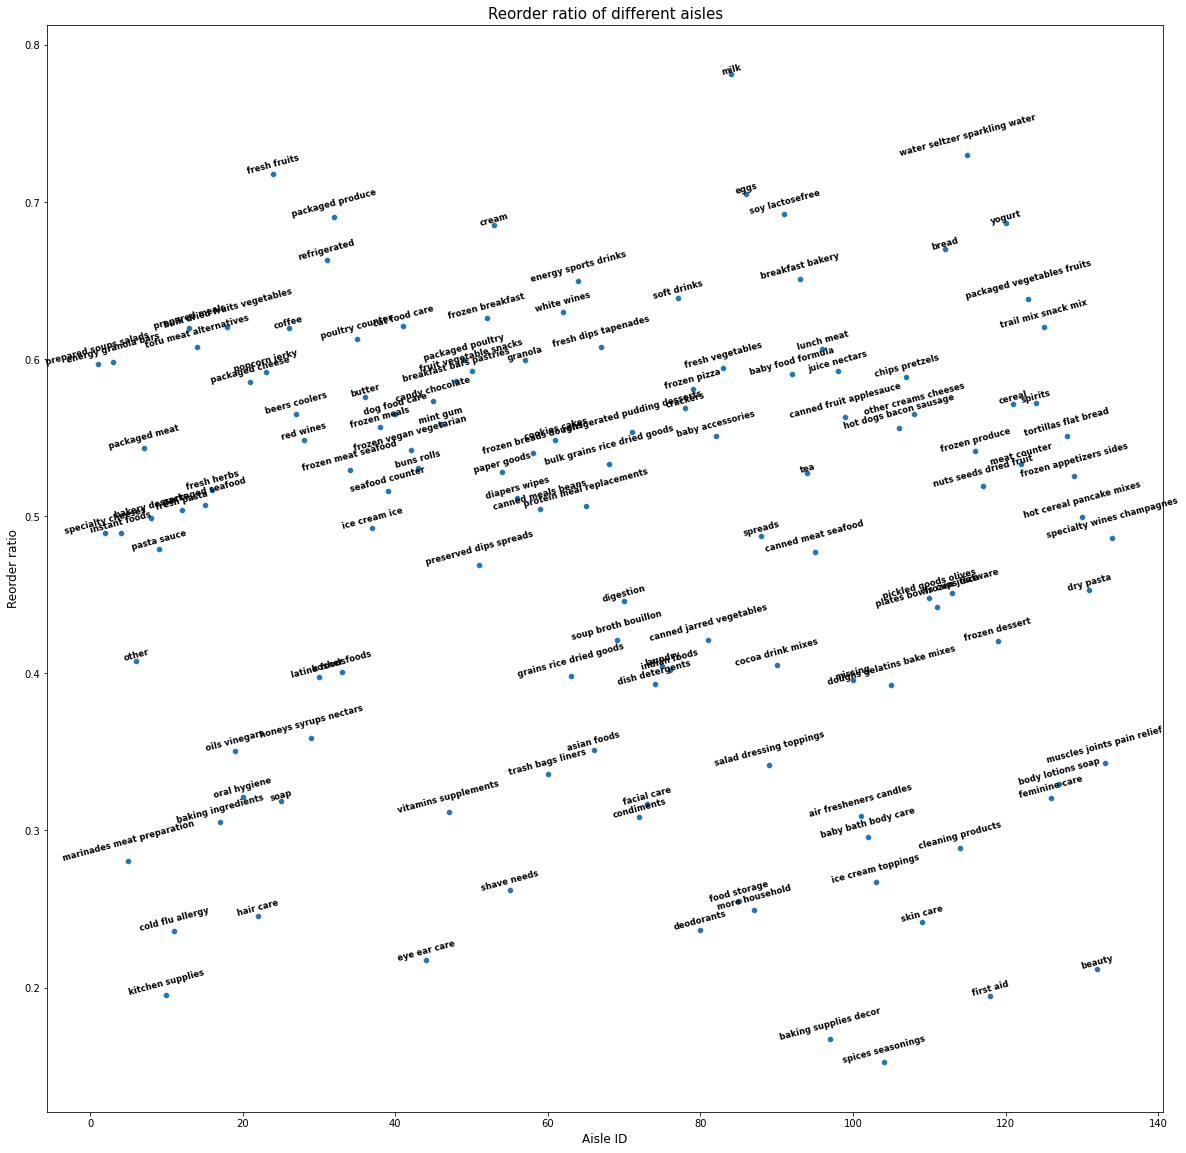

In [41]:
plt.figure(figsize = (20,20))
p1 = sns.scatterplot(x = 'aisle_id', y = 'reordered_percent', data = aisle_reorder)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle ID', fontsize=12)
plt.title("Reorder ratio of different aisles", fontsize=15)


for line in range(0,aisle_reorder.shape[0]):
     p1.text(aisle_reorder.aisle_id[line]+0.01, aisle_reorder.reordered_percent[line], 
             aisle_reorder['aisle'][line],horizontalalignment='center', 
     size='small', color='black', weight='semibold', rotation = 15)

### Add to cart order to reorder ratio: products that are added to the cart initially are more likely to be reordered again compared to the ones added later

In [42]:
cart_order_reordered = order_products_prior_full.groupby('add_to_cart_order')['reordered'].mean().reset_index()
cart_order_reordered.head()

,add_to_cart_order,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383


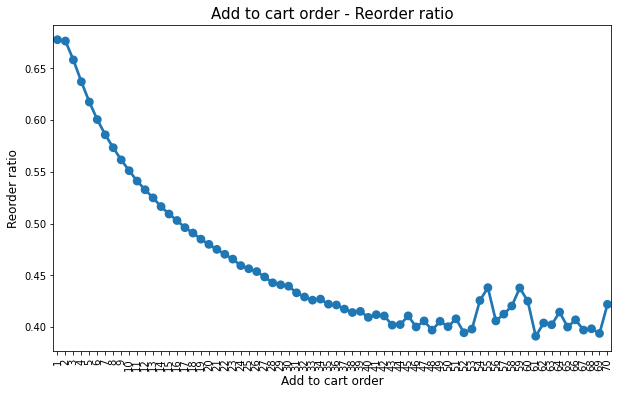

In [43]:
plt.figure(figsize = (10,6))
sns.pointplot(x = 'add_to_cart_order', y = 'reordered', data = cart_order_reordered[:70])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show();

### Reorder ratio based on hour of the day and day of the week for prior data

In [44]:
orders_products_prior_full = orders.merge(order_products_prior, on = 'order_id')
orders_products_prior_full.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [45]:
hour_prior_reorder = orders_products_prior_full.groupby('order_hour_of_day')['reordered'].agg('mean').reset_index()
hour_prior_reorder.head()

,order_hour_of_day,reordered
0,0,0.565500
1,1,0.557114
2,2,0.554455
3,3,0.559498
4,4,0.571195


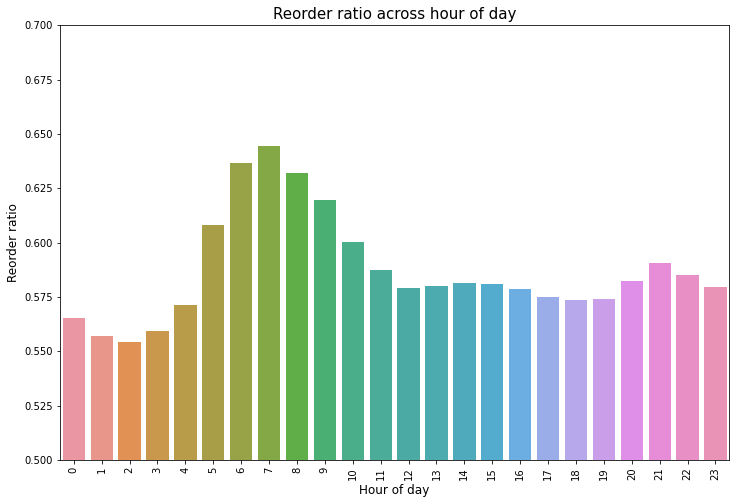

In [46]:
plt.figure(figsize=(12,8))
sns.barplot(x = 'order_hour_of_day', y = 'reordered', data = hour_prior_reorder)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show();

In [47]:
dow_prior_reorder = orders_products_prior_full.groupby('order_dow')['reordered'].agg('mean').reset_index()
dow_prior_reorder.head()

,order_dow,reordered
0,0,0.585276
1,1,0.603843
2,2,0.589771
3,3,0.586272
4,4,0.590979


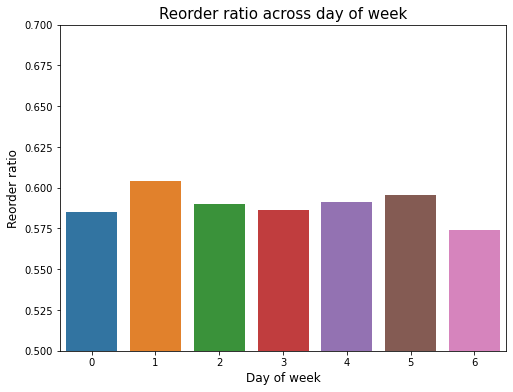

In [48]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'order_dow', y = 'reordered', data = dow_prior_reorder)
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.ylim(0.5, 0.7)
plt.show();

In [49]:
dow_hour = orders_products_prior_full.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean().reset_index()
dow_hour.head()

,order_dow,order_hour_of_day,reordered
0,0,0,0.576500
1,0,1,0.551792
2,0,2,0.552299
3,0,3,0.569427
4,0,4,0.546584


In [50]:
dow_hour_pivot = dow_hour.pivot('order_dow', 'order_hour_of_day', 'reordered')

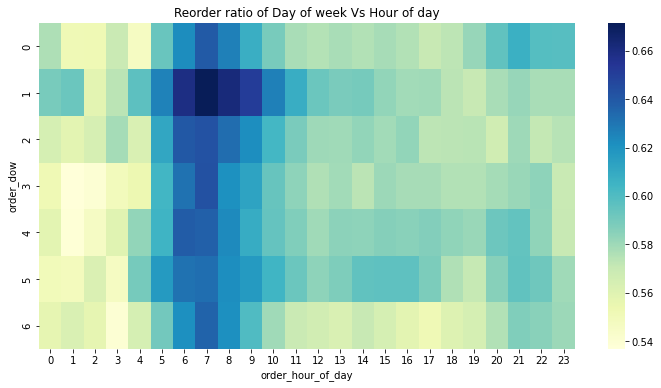

In [51]:
plt.figure(figsize=(12,6))
sns.heatmap(dow_hour_pivot, cmap="YlGnBu")
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()